# Final assignment

This is an empty notebook for your work. 

In [22]:
import geopandas as gpd

# Import Finalnd MML administrative borders without sea from Paituli via WFS
# dataset metadata: https://etsin.fairdata.fi/dataset/0a11579a-f420-4128-8e80-50b82d3905bd
borders = gpd.read_file(
        "https://paituli.csc.fi/geoserver/paituli/wfs"
        "?service=wfs"
        "&version=2.0.0"
        "&request=GetFeature"
        "&typeName=paituli:mml_hallinto_2025_milj_tk"
        "&srsName=EPSG:3857"
    ).set_crs("EPSG:3857")
borders.head()

,gml_id,GML_ID,NATCODE,NAMEFIN,NAMESWE,LANDAREA,FRESHWAREA,SEAWAREA,TOTALAREA,geometry
0,mml_hallinto_2025_milj_tk.1,1601200031,020,Akaa,Akaa,293.29,21.09,0.00,314.38,"MULTIPOLYGON (((2644253.85 8682996.56, 2645244..."
1,mml_hallinto_2025_milj_tk.2,1601200345,976,Ylitornio,Övertorneå,2030.68,182.09,0.00,2212.77,"MULTIPOLYGON (((2777240.71 10086395.84, 277727..."
2,mml_hallinto_2025_milj_tk.3,1601200393,694,Riihimäki,Riihimäki,121.01,4.54,0.00,125.55,"MULTIPOLYGON (((2753422.29 8578988.16, 2758469..."
3,mml_hallinto_2025_milj_tk.4,1601200188,905,Vaasa,Vasa,364.88,4.71,205.55,575.14,"MULTIPOLYGON (((2459646.49 9132570.54, 2460193..."
4,mml_hallinto_2025_milj_tk.5,1601200089,062,Föglö,Föglö,135.37,0.20,1733.50,1869.07,"MULTIPOLYGON (((2283726.71 8432016.15, 2283617..."


In [23]:
tampere = borders[borders["NAMEFIN"] == "Tampere"]
helsinki = borders[borders["NAMEFIN"] == "Helsinki"]

                          gml_id      GML_ID NATCODE  NAMEFIN     NAMESWE  \
56  mml_hallinto_2025_milj_tk.57  1601200575     837  Tampere  Tammerfors   

    LANDAREA  FRESHWAREA  SEAWAREA  TOTALAREA  \
56    526.16      164.55       0.0     690.71   

                                             geometry  
56  MULTIPOLYGON (((2671655.07 8808850.5, 2681774....  


<Axes: >

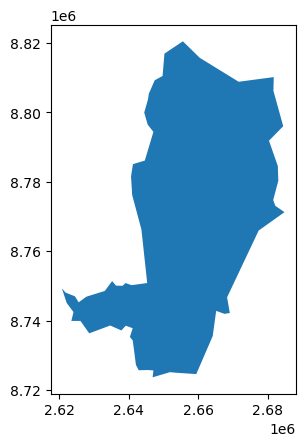

In [24]:
print(tampere)
tampere.plot()

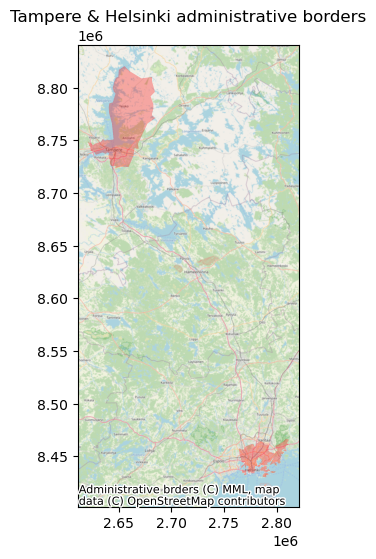

In [26]:
import contextily

ax = tampere.plot(
    figsize=(10, 6),
    color="red",
    alpha=0.3,
    linewidth=0,
)

helsinki.plot(
    ax=ax,
    color="red",
    alpha=0.3,
    linewidth=0,
)


# xmin, ymin, xmax, ymax = tampere.total_bounds
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

ax.set_title("Tampere & Helsinki administrative borders")

contextily.add_basemap(
    ax=ax,
    source=contextily.providers.OpenStreetMap.Mapnik,
    attribution=(
        "Administrative brders (C) MML, "
        "map data (C) OpenStreetMap contributors"
    )
)

## Using `snow` python module to read snow depth raster data from FMI

The dataset we will be using can be dowloaded from Paituli [here](https://paituli.csc.fi/download.html?data_id=il_daily_snow_10km_geotiff_euref).

A sample of the data has been provided in the repository to exemplify the usage. However, some of the code cells in this notebook require the full dataset.

The `open_snow_rasters` function provides a `missing_data` argument for loading the snow rasters when data is missing. For example, if you only want to load the sample rasters present in this repo:

In [32]:
import pathlib
import snow

# data directory where snow depth rasters are stored
DATA_DIR = pathlib.Path().resolve() / "data"

snow_rasters = snow.open_snow_rasters(DATA_DIR, missing_data=True)

Now we proceed with the full dataset.

*Skip this cell for a trial run but you'll need it for the Probability of White Christmas analysis further down*

In [ ]:
# directory where full dataset is present, change as needed
DATASET_DIRECTORY = pathlib.Path().resolve() / "ilmatiede" / "10km_daily_snow" / "geotiff"

# dict of snow rasters 1961-2022 by year
snow_rasters = snow.open_snow_rasters(DATASET_DIRECTORY)

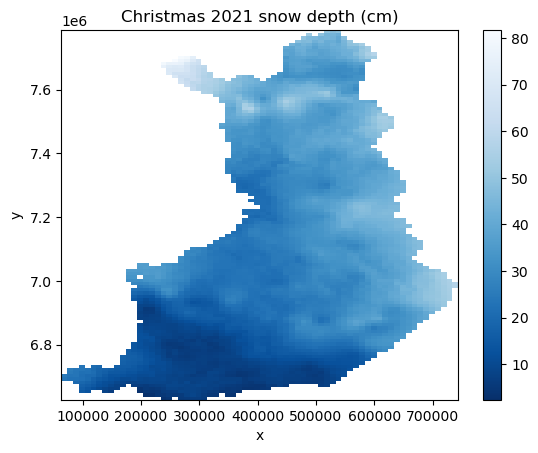

In [36]:
import matplotlib.pyplot as plt

xmas_snow = snow.xmas_snow_rasters(snow_rasters)

chosen_year = 2021
# Plot xmas snow for chosen year
xmas_snow[chosen_year].plot(cmap="Blues_r")
plt.title(f"Christmas {chosen_year} snow depth (cm)")
plt.show()

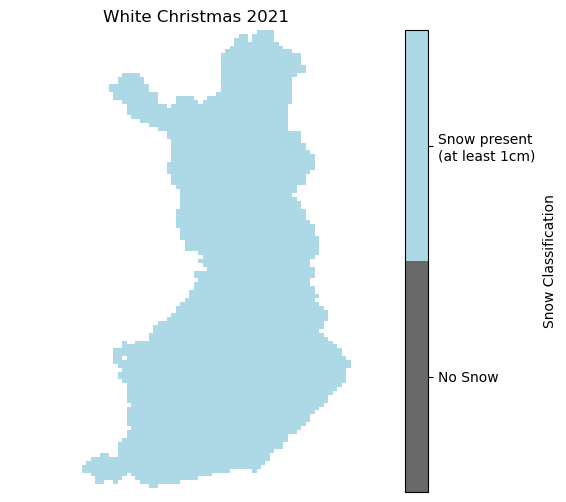

In [37]:
year = 2021

white_xmas_raster = snow.classify_white_xmas(xmas_snow[year])
snow.plot_white_xmas(white_xmas_raster, year)


## Probability of a White Christmas in Finland 
Now, we proceed to analyse the probability of having a white Christmas based on the 30 year period 1991-2020, inspired by [this FMI analysis](https://www.ilmatieteenlaitos.fi/joulunaika)

In [38]:
# Try to estimate how many of the christmas are white: for each year, snow_depth > 1 cm

start_year = 1991
end_year = 2020

white_xmas = {}
for year in range(start_year, end_year+1):
   # classify white christmas for each year as [0,1] = [No snow, White xmas]
   white_xmas[year] = snow.classify_white_xmas(xmas_snow[year]) - 1 # subtract 1 to start values at 0

white_xmas_sum = white_xmas[start_year]
for year in range(start_year+1, end_year+1):
   white_xmas_sum += white_xmas[year]

# change 30-year scale to 0-10
white_xmas_sum = white_xmas_sum / 3

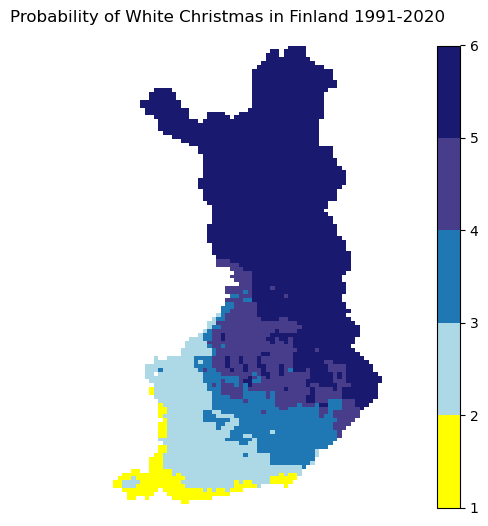

In [39]:
prob_white_xmas = snow.classify_prob_white_xmas(white_xmas_sum)
snow.plot_prob_white_xmas(prob_white_xmas, start_year, end_year)

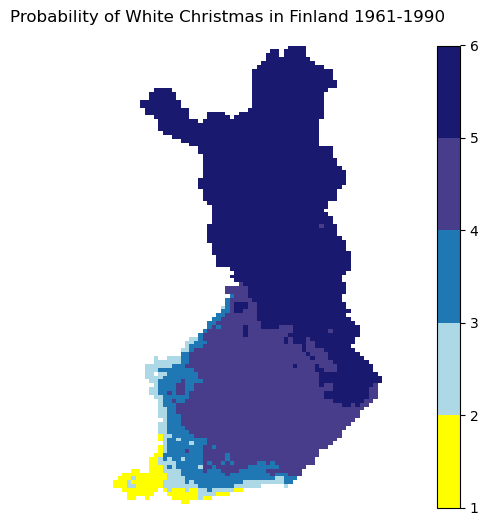

In [40]:
start_year = 1961
end_year = 1990

white_xmas = {}
for year in range(start_year, end_year+1):
   # classify white christmas for each year as [0,1] = [No snow, White xmas]
   white_xmas[year] = snow.classify_white_xmas(xmas_snow[year]) - 1 # subtract 1 to start values at 0

white_xmas_sum = white_xmas[start_year]
for year in range(start_year+1, end_year+1):
   white_xmas_sum += white_xmas[year]

# change 30-year scale to 0-10
white_xmas_sum = white_xmas_sum / 3

prob_white_xmas = snow.classify_prob_white_xmas(white_xmas_sum)
snow.plot_prob_white_xmas(prob_white_xmas, start_year, end_year)